In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os

In [2]:
# Load Dataset
df = pd.read_csv("data/feedback_data.csv")

In [3]:
# Display firt 5 rows
df.head()

,feedback,sentiment
0,The AI workshop was very informative and well ...,Positive
1,Machine learning concepts were explained clear...,Positive
2,I really enjoyed learning supervised machine l...,Positive
3,The hands-on coding sessions helped me underst...,Positive
4,The trainer explained concepts in a simple and...,Positive


In [4]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   feedback   182 non-null    object
 1   sentiment  182 non-null    object
dtypes: object(2)
memory usage: 3.0+ KB


In [5]:
df['sentiment'].value_counts()

Positive    82
Neutral     50
Negative    50
Name: sentiment, dtype: int64

In [6]:
# Word Count Analysis
df['word_count'] = df['feedback'].apply(lambda x: len(x.split()))

df.groupby('sentiment')['word_count'].mean()

sentiment
Negative    6.660000
Neutral     7.660000
Positive    6.914634
Name: word_count, dtype: float64

In [7]:
# Text Preprocessing

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

In [8]:
# Apply preprocessing

df['clean_feedback'] = df['feedback'].apply(preprocess_text)

df[['feedback', 'clean_feedback']].head()

,feedback,clean_feedback
0,The AI workshop was very informative and well ...,ai workshop informative well structured
1,Machine learning concepts were explained clear...,machine learning concept explained clearly goo...
2,I really enjoyed learning supervised machine l...,really enjoyed learning supervised machine lea...
3,The hands-on coding sessions helped me underst...,handson coding session helped understand ml be...
4,The trainer explained concepts in a simple and...,trainer explained concept simple easy way


In [20]:
# Create Custom Stopwords List
# Domain-specific stopwords (college AI/ML workshop related)

domain_stopwords = {
    # General education / training words
    "workshop", "training", "session", "sessions", "program",
    "course", "classes", "class",

    # AI / ML generic terms (appear everywhere, low sentiment value)
    "ai", "ml", "machine", "learning", "algorithm", "algorithms",
    "model", "models", "data", "dataset",

    # Teaching / delivery words
    "trainer", "instructor", "teaching", "explained", "explanation",
    "topic", "topics", "concept", "concepts",

    # Coding / tools (very frequent)
    "python", "code", "coding", "libraries", "library",
    "numpy", "pandas",

    # Student-related words
    "student", "students", "we", "us",

    # Generic filler words
    "overall", "experience", "part", "time", "day",
    "things", "stuff", "feel", "felt"
}

# Combine normal English stopwords + domain-specific stopwords
custom_stopwords = stop_words.union(domain_stopwords)

In [21]:
# Word Cloud function

def generate_wordcloud(text, title):
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords,
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

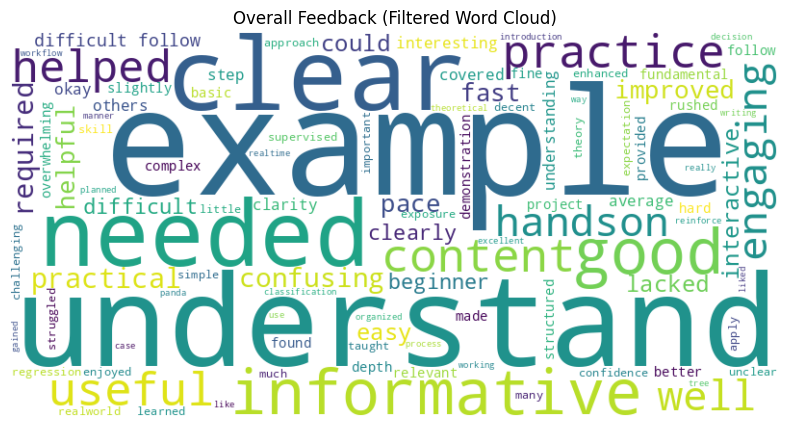

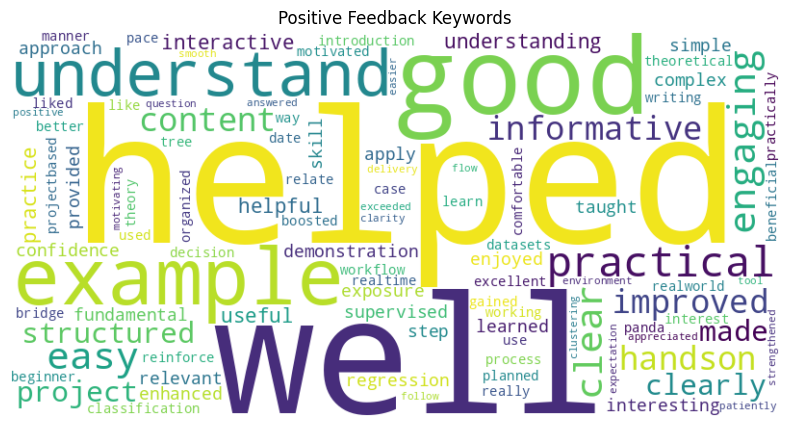

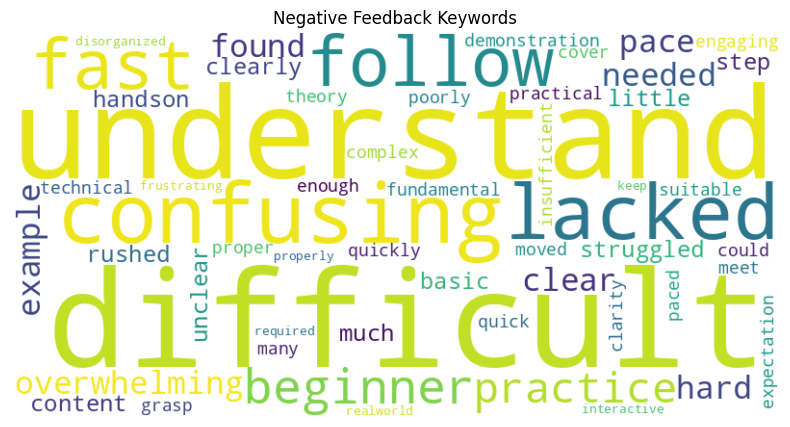

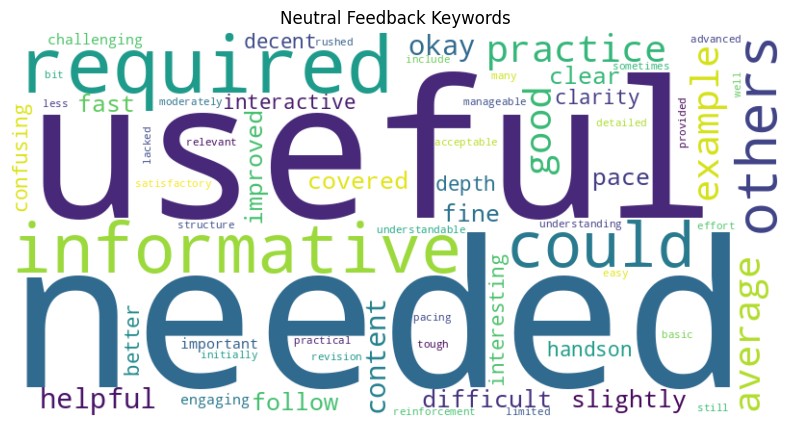

In [22]:
# Generate Clean Word Clouds
# Overall
all_text = " ".join(df['clean_feedback'])
generate_wordcloud(all_text, "Overall Feedback (Filtered Word Cloud)")

# Sentiment-wise
positive_text = " ".join(df[df['sentiment']=="Positive"]['clean_feedback'])
negative_text = " ".join(df[df['sentiment']=="Negative"]['clean_feedback'])
neutral_text  = " ".join(df[df['sentiment']=="Neutral"]['clean_feedback'])

generate_wordcloud(positive_text, "Positive Feedback Keywords")
generate_wordcloud(negative_text, "Negative Feedback Keywords")
generate_wordcloud(neutral_text, "Neutral Feedback Keywords")

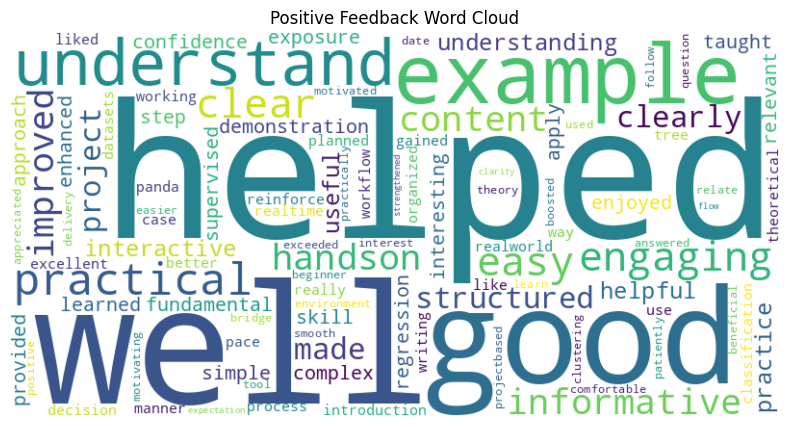

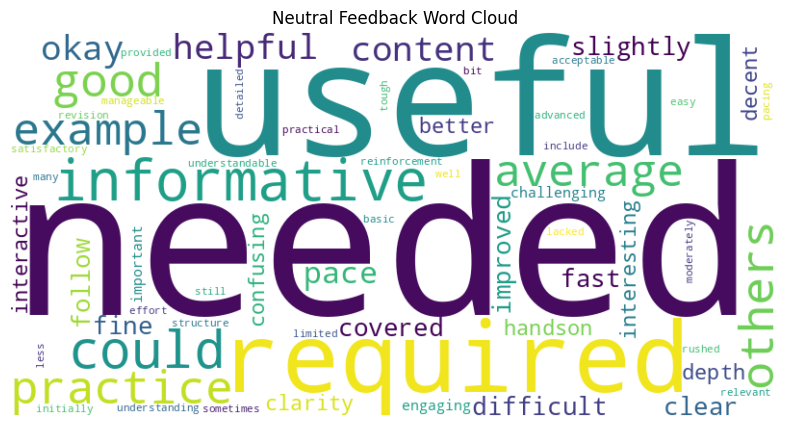

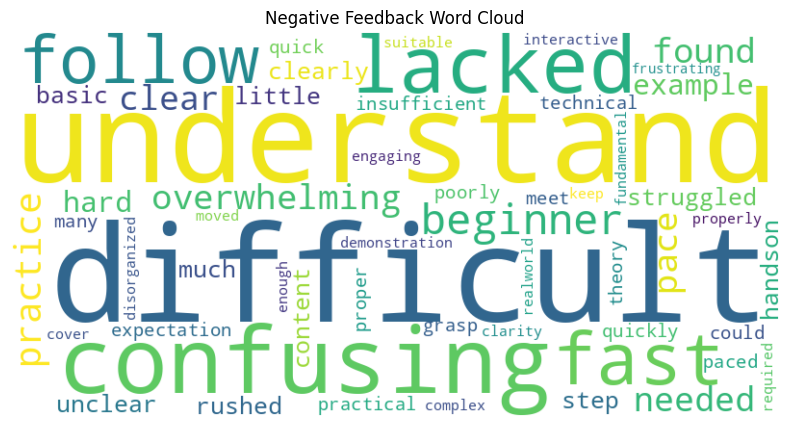

In [23]:
# Sentiment-wise Word Clouds
positive_text = " ".join(df[df['sentiment']=="Positive"]['clean_feedback'])
neutral_text  = " ".join(df[df['sentiment']=="Neutral"]['clean_feedback'])
negative_text = " ".join(df[df['sentiment']=="Negative"]['clean_feedback'])

generate_wordcloud(positive_text, "Positive Feedback Word Cloud")
generate_wordcloud(neutral_text, "Neutral Feedback Word Cloud")
generate_wordcloud(negative_text, "Negative Feedback Word Cloud")

In [24]:
# Feature Extraction (TF-IDF)
X = df['clean_feedback']
y = df['sentiment']

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(X)

In [25]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [26]:
# Train Model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [27]:
# Model Evaluation
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7567567567567568

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.56      0.71         9
     Neutral       0.80      0.73      0.76        11
    Positive       0.68      0.88      0.77        17

    accuracy                           0.76        37
   macro avg       0.83      0.72      0.75        37
weighted avg       0.79      0.76      0.75        37



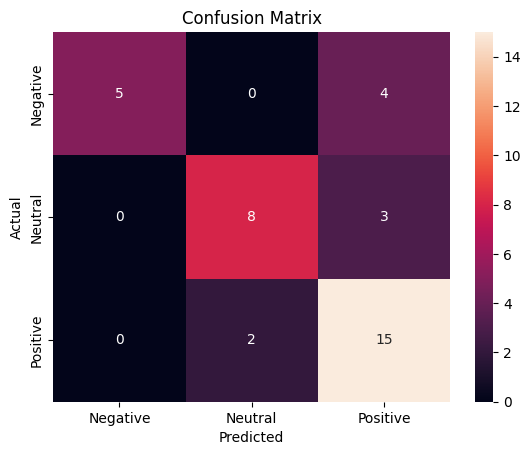

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
# Create model directory if not exists
os.makedirs("model", exist_ok=True)

# Save model & vectorizer
pickle.dump(model, open("model/sentiment_model.pkl", "wb"))
pickle.dump(tfidf, open("model/vectorizer.pkl", "wb"))

print("✅ Model and vectorizer saved successfully in 'model/' folder")

✅ Model and vectorizer saved successfully in 'model/' folder


In [31]:
# load & Test Model
loaded_model = pickle.load(open("model/sentiment_model.pkl", "rb"))
loaded_vectorizer = pickle.load(open("model/vectorizer.pkl", "rb"))

sample_text = "The workshop was very informative and engaging. The hands-on coding sessions helped me understand machine learning concepts clearly, and the trainer explained the algorithms well"
sample_clean = preprocess_text(sample_text)
sample_vec = loaded_vectorizer.transform([sample_clean])

print("Predicted Sentiment:", loaded_model.predict(sample_vec)[0])

Predicted Sentiment: Positive
